## Download do dataset

Define variáveis de ambiente e baixa o dataset de transações fraudulentas do Kaggle.

In [2]:
from google.colab import userdata
import os
import kagglehub

# Definindo as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = userdata.get('userName')
os.environ['KAGGLE_KEY'] = userdata.get('apiKey')

# Baixar o dataset usando o Kagglehub
kagglehub.dataset_download('mlg-ulb/creditcardfraud')

'/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3'

## Carregamento e Análise Inicial dos Dados

Carrega o dataset e exibe a distribuição inicial das classes (fraudulentas e não fraudulentas).

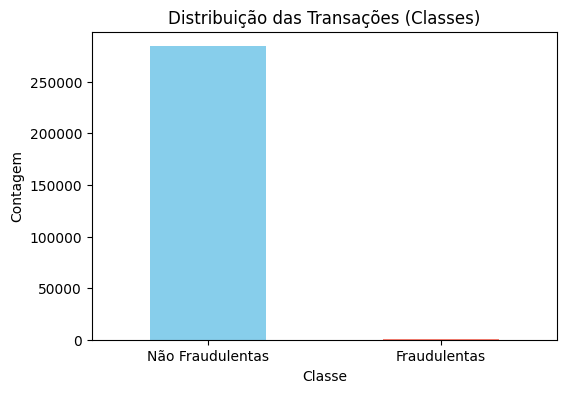

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Carregar os dados
dataset_dir = '/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3'
file_path = os.path.join(dataset_dir, 'creditcard.csv')
df = pd.read_csv(file_path)

# Remover linhas com valores NaN na coluna 'Class'
df = df.dropna(subset=['Class'])

# Análise da distribuição das classes
plt.figure(figsize=(6, 4))
df['Class'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição das Transações (Classes)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.xticks([0, 1], ['Não Fraudulentas', 'Fraudulentas'], rotation=0)
plt.show()

## Pré-processamento dos Dados

Separa os dados em variáveis de entrada e saída.

In [4]:
X = df.drop(columns=['Class'])
y = df['Class']

## Divisão de Dados em Treino e Teste

Divide os dados em conjuntos de treinamento e teste, treina o modelo com os dados de treinamento, faz previsões e avalia o desempenho no conjunto de teste usando a matriz de confusão e o relatório de classificação.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Balanceamento das Classes com SMOTE

Aplica o balanceamento SMOTE nas classes do conjunto de treino para melhorar a performance do modelo.

In [6]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Treinamento do Modelo

Treina um modelo de classificação com Random Forest nos dados balanceados.

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Treinar o modelo com o conjunto balanceado
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

## Avaliação do Modelo

Avalia o modelo com o conjunto de teste e exibe as métricas de desempenho.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo com o conjunto de teste
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Calcular a acurácia para o conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")


Matriz de Confusão:
[[56848    16]
 [   17    81]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Acurácia no conjunto de teste: 0.9994


## Análise de Importância das Features

Exibe as 10 features mais importantes na classificação das transações.

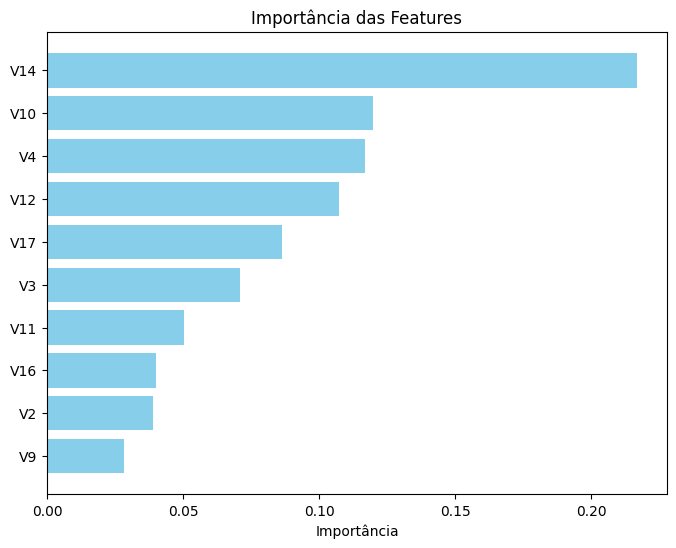

In [9]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # As 10 features mais importantes

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importância')
plt.title('Importância das Features')
plt.show()

## Matriz de Confusão Normalizada

Gera uma matriz de confusão normalizada para comparar previsões com valores reais.

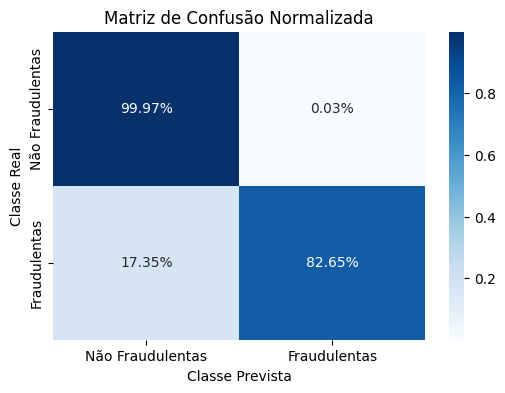

In [10]:
import seaborn as sns

# Plotar matriz de confusão normalizada
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=['Não Fraudulentas', 'Fraudulentas'], yticklabels=['Não Fraudulentas', 'Fraudulentas'])
plt.title('Matriz de Confusão Normalizada')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

## Curva ROC e AUC

Calcula e plota a curva ROC e AUC para avaliar a taxa de acerto do modelo.

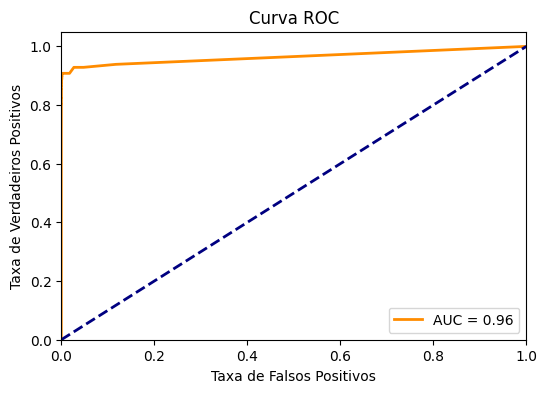

In [11]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC e AUC
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Gráfico de Pizza com Resultados das Previsões

Mostra a distribuição das previsões em transações fraudulentas e não fraudulentas.

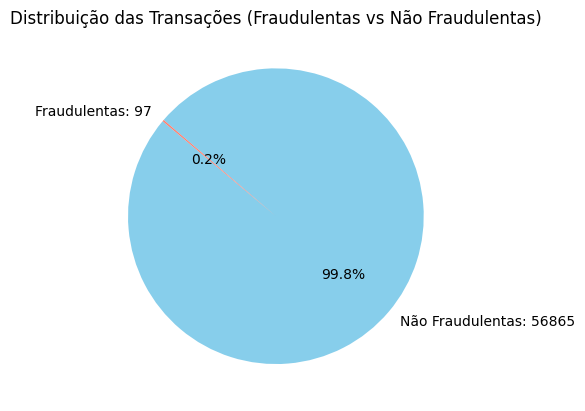

In [12]:
predicted_counts = pd.Series(y_pred).value_counts().sort_index()
predicted_labels = ['Não Fraudulentas', 'Fraudulentas']
predicted_counts.plot(
    kind='pie',
    labels=[f"{label}: {count}" for label, count in zip(predicted_labels, predicted_counts)],
    startangle=140,
    colors=['skyblue', 'salmon'],
    autopct='%1.1f%%'
)
plt.title('Distribuição das Transações (Fraudulentas vs Não Fraudulentas)')
plt.ylabel('')
plt.show()